In this notebook we add some data augmentation, to try ti increase accuracy on test set, since it is very low.

In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN/

/gdrive/MyDrive/Challenge1_Mio/only_tomato_CNN


In [ ]:
!unzip only_tomato.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: only_tomato/train/Tomato/42653.jpg  
  inflating: only_tomato/train/Tomato/38640.jpg  
  inflating: only_tomato/train/Tomato/39219.jpg  
  inflating: only_tomato/train/Tomato/41120.jpg  
  inflating: only_tomato/train/Tomato/41564.jpg  
  inflating: only_tomato/train/Tomato/40160.jpg  
  inflating: only_tomato/train/Tomato/42811.jpg  
  inflating: only_tomato/train/Tomato/40907.jpg  
  inflating: only_tomato/train/Tomato/39684.jpg  
  inflating: only_tomato/train/Tomato/43993.jpg  
  inflating: only_tomato/train/Tomato/42089.jpg  
  inflating: only_tomato/train/Tomato/38356.jpg  
  inflating: only_tomato/train/Tomato/21344.jpg  
  inflating: only_tomato/train/Tomato/38164.jpg  
  inflating: only_tomato/train/Tomato/43943.jpg  
  inflating: only_tomato/train/Tomato/38513.jpg  
  inflating: only_tomato/train/Tomato/39466.jpg  
  inflating: only_tomato/train/Tomato/43731.jpg  
  inflating: only_tomato/train/Tomato/21439.jpg  


#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


#Loading data & folder Exploring

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_dir = 'only_tomato'

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

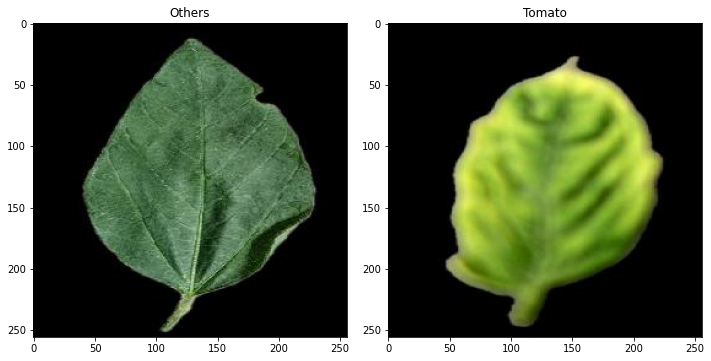

In [ ]:
# Plot example images from dataset
labels = ['Others','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(10, 10))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))

plt.tight_layout()
plt.show()

#Data Generator

Import:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

# Create an instance of ImageDataGenerator with Data Augmentation
# We decided to allow 360° rotation since it is possible to have rotated leaves.
# We introduced the zoom and the shift, on the base of the given dataset, where not all the photos are centered
noaug_train_data_gen = ImageDataGenerator(rotation_range=180, height_shift_range=70, width_shift_range=120, zoom_range=0.6, horizontal_flip=True, vertical_flip=True, fill_mode='constant', rescale=1/255.)


# Model with large batch size
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=120,
                                               shuffle=True,
                                               seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=120,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=120,
                                               shuffle=False,
                                               seed=seed)


Found 13295 images belonging to 2 classes.
Found 2658 images belonging to 2 classes.
Found 1775 images belonging to 2 classes.


"aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,\n                                               target_size=(256, 256),\n                                               color_mode='rgb',\n                                               classes=None,\n                                               batch_size=8,\n                                               shuffle=True,\n                                               seed=seed)"

#Characteristics

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

In [ ]:
# Model form exercise session
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=2, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

#Building Model

In [ ]:
# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

#Training the model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [early_stopping],
).history

Epoch 1/200
111/111 [==============================] - 8089s 73s/step - loss: 0.6195 - accuracy: 0.6794 - val_loss: 0.5444 - val_accuracy: 0.6791
Epoch 2/200
111/111 [==============================] - 195s 2s/step - loss: 0.4984 - accuracy: 0.7695 - val_loss: 0.6535 - val_accuracy: 0.7265
Epoch 3/200
111/111 [==============================] - 193s 2s/step - loss: 0.4091 - accuracy: 0.8191 - val_loss: 0.3284 - val_accuracy: 0.8717
Epoch 4/200
111/111 [==============================] - 195s 2s/step - loss: 0.3525 - accuracy: 0.8541 - val_loss: 0.3081 - val_accuracy: 0.8804
Epoch 5/200
111/111 [==============================] - 194s 2s/step - loss: 0.3071 - accuracy: 0.8728 - val_loss: 0.3789 - val_accuracy: 0.8299
Epoch 6/200
111/111 [==============================] - 195s 2s/step - loss: 0.2561 - accuracy: 0.8962 - val_loss: 0.1596 - val_accuracy: 0.9409
Epoch 7/200
111/111 [==============================] - 194s 2s/step - loss: 0.2372 - accuracy: 0.9052 - val_loss: 0.3080 - val_accurac

#Saving the model

In [ ]:
# Save best epoch model
model.save("Data_Augemntation_only_tomatoll")

INFO:tensorflow:Assets written to: Data_Augemntation_only_tomato/assets


INFO:tensorflow:Assets written to: Data_Augemntation_only_tomato/assets


#Plot training error and validation error

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

NameError: ignored

# Show predictions

In [ ]:
# Load model

model = tfk.models.load_model("Data_Augemntation_only_tomato")

In [ ]:
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=128,
                                               shuffle=False,
                                               seed=seed)


Found 1775 images belonging to 2 classes.


In [ ]:
model_metrics = model.evaluate(test_gen, return_dict=True)
print(model_metrics)

14/14 [==============================] - 316s 24s/step - loss: 0.0993 - accuracy: 0.9634
{'loss': 0.099319688975811, 'accuracy': 0.9633802771568298}


In [ ]:
predictions = model.predict_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
# We use this snippet of code to figure out where (in which class) the mispredictions are more relevant

predicted_classes = np.argmax(predictions, axis=-1)
true_classes = test_gen.classes

# Predicted ok
ok = [0]*15

# Errors
error = [0]*15

# Correctly predicted with good percentage
good = [0]*15

for i in range(0, 1775):

  if(predictions[i][1] > 0.5):
    if true_classes[i] == 1:
      ok[1] += 1
      if(predictions[i][1] > 0.4):
        good[1] += 1 
    else:
      error[1] += 1
  elif(predictions[i][0] > 0.5):
    if true_classes[i] == 0:
      ok[0] +=1
    else:
      error[0] += 1
print("ok:", ok)
print("error:", error)
print("good:", good)

ok: [1170, 540, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
error: [31, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
number: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
good: [0, 540, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(128, 256, 256, 3)
(1, 256, 256, 3)


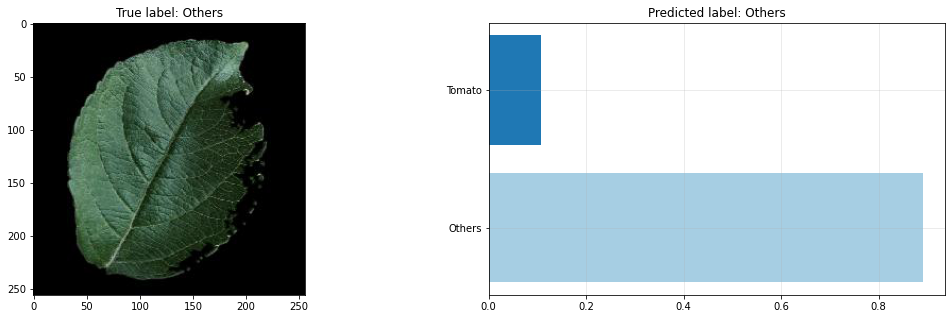

In [ ]:
batch = next(test_gen)
target = batch[1]
batch = batch[0]

# Get first image
image = batch[0] # batch size = 120
print(batch.shape)
target_label = labels[np.argmax(target[0])]

y = np.expand_dims(image, axis=0)
print(y.shape)
predictions = model.predict(y)
predictions.shape

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)
ax1.imshow(image)
ax1.set_title('True label: '+target_label)
ax2.barh(labels, predictions[0], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions[0])])
ax2.grid(alpha=.3)
plt.show()